## Qiskit Nature 

The Qiskit Nature module provides us with the tooling to easily integrate with and leverage the well-established classical software packages for quantum chemistry simulations.

The classical packages provides the tools for defining the problem, setting up the calculation, along with carrying out the classical parts of the calculations needed to get going.
When the problem has been defined it can then be handed over to Qiskit Nature, where it will be transformed into one of three classes: Electronic or Vibrational structure problem, or a lattice model problem. 
The problem instance can then be passed to a solver to perform the desired algorithm, which is then translated into the language of quantum circuits, and we are now ready to run out Qiskit program.

Qiskit Nature is an open-source framework which supports solving quantum mechanical natural science problems using quantum computing algorithms. This includes finding ground and excited states of electronic and vibrational structure problems, measuring the dipole moments of molecular systems, solving the Ising and Fermi-Hubbard models on lattices, and much more.




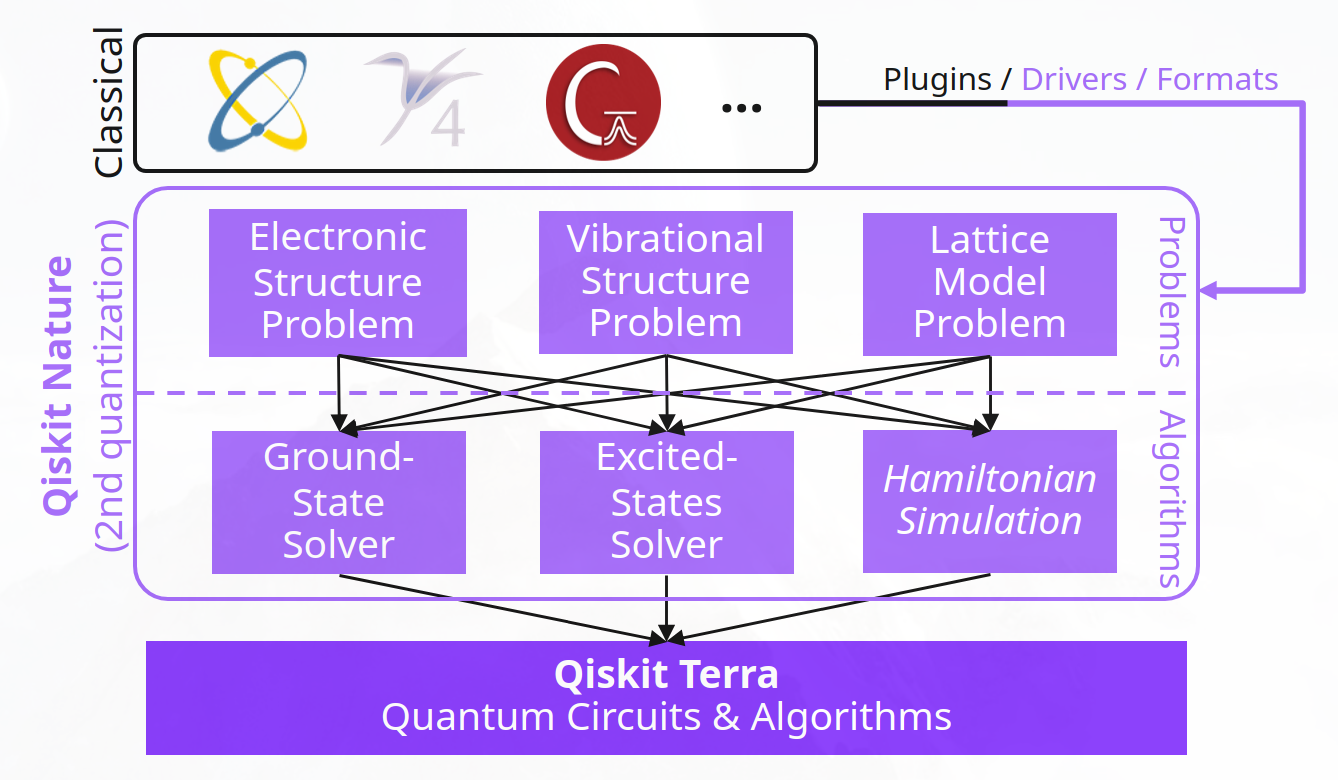

The code comprises various modules revolving around:

* data loading from chemistry drivers or file formats
* second-quantized operator construction and manipulation
* translating from the second-quantized to the qubit space
* a quantum circuit library of natural science targeted ansatze
* natural science specific algorithms and utilities to make the use of Qiskit Terra’s algorithms easier
* and much more

As you can see, the package is logically divided into two concepts:

**Problems:** which are representations of scientific problems to which one seeks a solution

**Algorithms:** which provide the means to find solutions to said problems
In each of these cases, Qiskit Nature has three pillars:

##### Problems:
1. Electronic Structure Problem: representing the problem of the electronic Schrödinger equation of molecular systems
2. Vibrational Structure Problem: representing the problem posed by the Watson Hamiltonian of molecular systems
3. Lattice Model Problem: representing problems defined on lattices

##### Algorithms:
* Ground State Solver: for finding the ground state of a problem
* Excited States Solver: for finding excited states of a problem
* Hamiltonian Simulation: to simulate dynamics of a problem


Some of these concepts have already been present in earlier versions of Qiskit Nature, but were not as clearly separated. Furthermore, the integration with classical codes has been very restrictive in older versions, limiting not only the potential applications of such integrations, but also the capabilities of our BaseProblem representation, and its usage in the remainder of the package.

### Transforming a chemistry problem into a circuit 


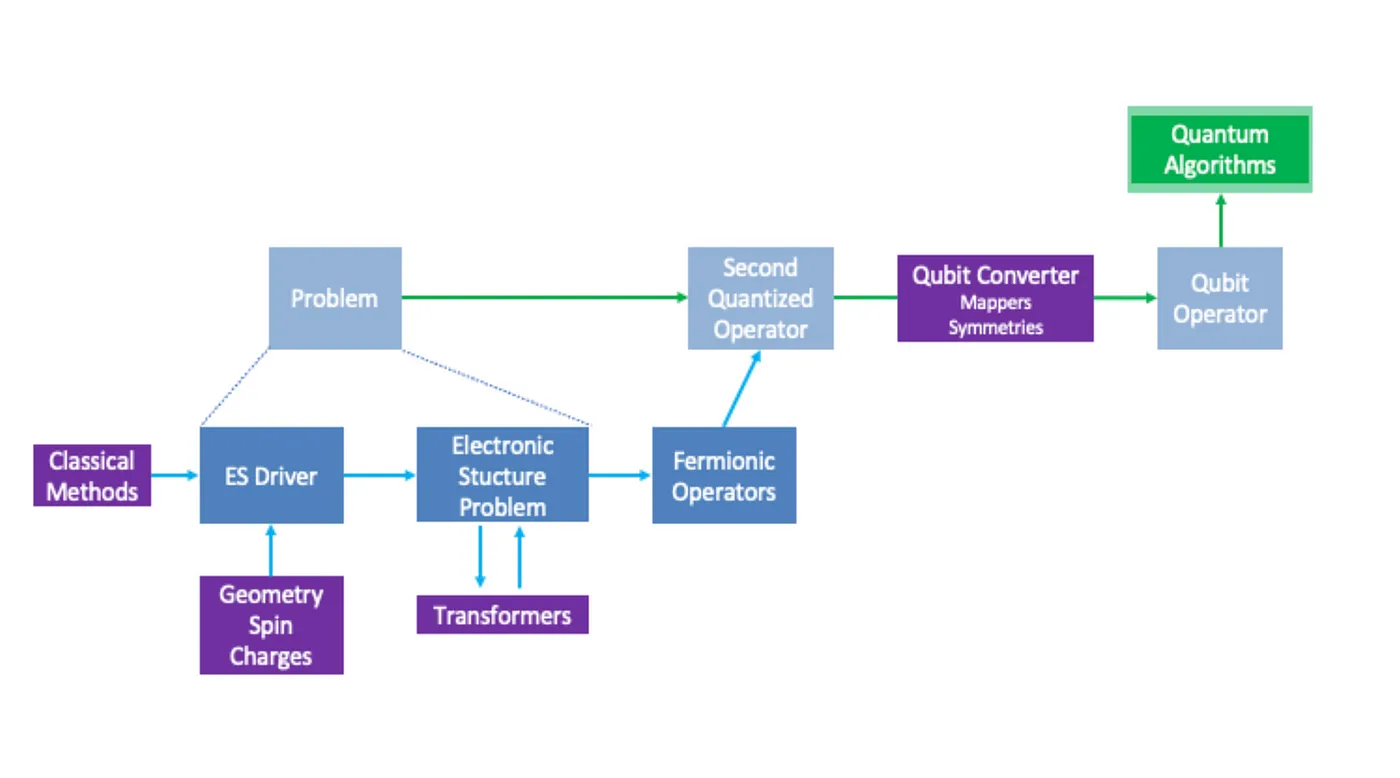

In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
import numpy as np
%config InlineBackend.figure_format='retina'

# Use PySCF, a classical computational chemistry software
# package, to compute the one-body and two-body integrals in
# electronic-orbital basis, necessary to form the Fermionic operator

list_of_total_energies = []
list_of_dists = []
for i in range(30):
    atomic_distances = 0.235+0.06*i
    rounded_dists = np.round(atomic_distances)
    list_of_dists.append(atomic_distances)
    driver = PySCFDriver(
        atom='H .0 .0 .0; H .0 .0 ' + str(atomic_distances),
        unit=DistanceUnit.ANGSTROM,
        basis='sto3g',
    )
    problem = driver.run()

    # setup the qubit mapper
    from qiskit_nature.second_q.mappers import ParityMapper

    mapper = ParityMapper(num_particles = problem.num_particles)

    # setup the classical optimizer for the VQE
    from qiskit.algorithms.optimizers import L_BFGS_B

    optimizer = L_BFGS_B()

    # setup the estimator primitive for the VQE
    from qiskit.primitives import Estimator

    estimator = Estimator()

    # setup the ansatz for VQE
    from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state = HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    # set up our actual VQE instance
    from qiskit.algorithms.minimum_eigensolvers import VQE

    vqe = VQE(estimator, ansatz, optimizer)
    # ensure that the optimizer starts in the all-zero state which corresponds to
    # the Hartree-Fock starting point
    vqe.initial_point = [0] * ansatz.num_parameters

    # prepare the ground-state solver and run it
    from qiskit_nature.second_q.algorithms import GroundStateEigensolver

    algorithm = GroundStateEigensolver(mapper, vqe)

    electronic_structure_result = algorithm.solve(problem)
    electronic_structure_result.formatting_precision = 6
    print(electronic_structure_result)


    list_of_total_energies.append(electronic_structure_result.total_energies[0])

/opt/conda/lib/python3.10/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.447347
  - computed part:      -2.447347
~ Nuclear repulsion energy (Hartree): 2.251818
> Total ground state energy (Hartree): -0.19553
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.444086]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.444086]
    - computed part:      [0.0  0.0  0.444086]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.372145
  - computed part:      -2.372145
~ Nuclear repulsion energy (Hartree): 1.793821
> Total ground state energy (Hartree): -0.578324
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.557469]
 
  0: 
  * Elec

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(list_of_dists,list_of_total_energies)
plt.xlabel('Interatomic Distance [å]')
plt.ylabel('Total Energy [Hartree]')